In [50]:
seed_value=0
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(555)
import tensorflow as tf
tf.random.set_random_seed(seed_value)  
import warnings
warnings.filterwarnings("ignore")

In [2]:
#basic imports 
#import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import mplleaflet
#import geopandas
from IPython.display import display
import gmplot
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
import cufflinks as cf
import plotly.express as px
cf.go_offline()
from sklearn.cluster import KMeans
from statsmodels.tsa.stattools import adfuller
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import itertools
pd.plotting.register_matplotlib_converters()
from statsmodels.tools.eval_measures import rmse

from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from sklearn.metrics import mean_squared_error


Using TensorFlow backend.


In [3]:
df0=pd.read_csv('df0new.csv')

In [4]:
df0['time']=pd.to_datetime(df0['time'])
df0.sort_values('time',inplace=True)
df0.reset_index(inplace=True,drop=True)
df0.set_index('time',inplace=True)
df0['w']=10**df0['Mpf']
df0=df0[['w']]
dft=df0.resample(rule='MS').sum()
dft['w']=dft['w']/100
dft = dft.reset_index()
dft.set_index('time',inplace=True)

## Finalizing

In [5]:
well=pd.read_csv('well_cluster0_for_sarimax.csv')

In [6]:
def time_index(df):
    df['date']=pd.to_datetime(df['date'])
    df.sort_values('date',inplace=True)
    df.reset_index(inplace=True,drop=True)
    df.set_index('date',inplace=True)
    return df
    
def resample_data_count(df):
    df_mc=df.resample(rule='MS').count()
    return df_mc   

In [7]:
wellt=time_index(well)
wellt=resample_data_count(wellt)
wellt=wellt[1:66]

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
welltS = scaler.fit_transform(wellt[['number of fractures']])
dftS=scaler.fit_transform(dft[['w']])

In [9]:
welltScaled=pd.DataFrame(welltS)
dftScaled=pd.DataFrame(dftS)


In [10]:
from pandas import concat
from sklearn.metrics import mean_squared_error
data=list(dftScaled[0])
n_vars = 1 if type(data) is list else data.shape[1]
df = pd.DataFrame(data)
n_in=7
n_out=1
cols, names = list(), list()
# input sequence (t-n, ... t-1)
for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
# forecast sequence (t, t+1, ... t+n)
for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
# put it all together
agg = concat(cols, axis=1)
agg.columns = names


In [11]:
agg['number of fractures(t)']=list(welltScaled[0])
agg.dropna(inplace=True)

In [ ]:
#cols=['number of fractures(t)','var1(t-12)',
 'var1(t-11)',
 'var1(t-10)',
 'var1(t-9)',
 'var1(t-8)',
 'var1(t-7)',
 'var1(t-6)',
 'var1(t-5)',
 'var1(t-4)',
 'var1(t-3)',
 'var1(t-2)','var1(t-1)','var1(t)']

In [12]:
agg.head()
cols = agg.columns.tolist()
cols = cols[-1:] + cols[:-1]
agg = agg[cols]


In [13]:
#Split into train and test
values = agg.values
train_size = int(values.shape[0] * 0.8)
train=values[:train_size,:]
test=values[train_size:,:]
test.shape
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(46, 1, 8) (46,) (12, 1, 8) (12,)


Train on 46 samples, validate on 12 samples
Epoch 1/80
46/46 [==============================] - 1s 20ms/step - loss: 0.0890 - val_loss: 0.0569
Epoch 2/80
46/46 [==============================] - 0s 2ms/step - loss: 0.0714 - val_loss: 0.0534
Epoch 3/80
46/46 [==============================] - 0s 2ms/step - loss: 0.0678 - val_loss: 0.0535
Epoch 4/80
46/46 [==============================] - 0s 2ms/step - loss: 0.0667 - val_loss: 0.0530
Epoch 5/80
46/46 [==============================] - 0s 2ms/step - loss: 0.0656 - val_loss: 0.0525
Epoch 6/80
46/46 [==============================] - 0s 2ms/step - loss: 0.0646 - val_loss: 0.0522
Epoch 7/80
46/46 [==============================] - 0s 2ms/step - loss: 0.0636 - val_loss: 0.0517
Epoch 8/80
46/46 [==============================] - 0s 2ms/step - loss: 0.0627 - val_loss: 0.0513
Epoch 9/80
46/46 [==============================] - 0s 2ms/step - loss: 0.0621 - val_loss: 0.0512
Epoch 10/80
46/46 [==============================] - 0s 2ms/step - loss: 

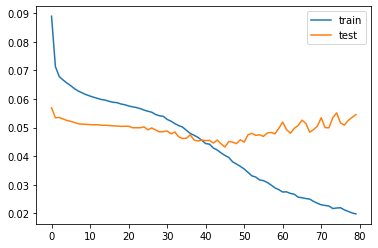

In [49]:
#design the model
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(75,activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=80, batch_size=1, validation_data=(test_X, test_y), shuffle=False)
# plot history
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [46]:

test_pr = model.predict(test_X)
train_pr=model.predict(train_X)
train_pr_scaled=scaler.inverse_transform(train_pr)
test_pr_scaled=scaler.inverse_transform(test_pr)
prediction=np.vstack((train_pr_scaled, test_pr_scaled))

In [390]:
scaler.inverse_transform(test_y)

array([[  0.        ],
       [ 47.18078408],
       [101.75402997],
       [ 26.57918308],
       [ 25.96744972],
       [ 36.03008064],
       [204.70877932],
       [ 22.58925412],
       [ 24.0214941 ],
       [ 72.07139838],
       [  4.81533606],
       [ 14.55403923],
       [  4.90895877],
       [  0.        ],
       [ 15.0003113 ],
       [  6.30957344]])

In [388]:
test_y = test_y.reshape((len(test_y), 1))

In [392]:
dftb=dft[-16:]

In [394]:
dftb['prediction']=scaler.inverse_transform(yhat)

## Complete code: Tuning

In [180]:
from pandas import concat
from sklearn.metrics import mean_squared_error
import time
df0=pd.read_csv('df0new.csv')
well=pd.read_csv('well_cluster0_for_sarimax.csv')

In [181]:
df0['time']=pd.to_datetime(df0['time'])
df0.sort_values('time',inplace=True)
df0.reset_index(inplace=True,drop=True)
df0.set_index('time',inplace=True)
df0['w']=10**df0['Mpf']
df0=df0[['w']]
dft=df0.resample(rule='MS').sum()
dft['w']=dft['w']/100
dft = dft.reset_index()
dft.set_index('time',inplace=True)

In [182]:
def time_index(df):
    df['date']=pd.to_datetime(df['date'])
    df.sort_values('date',inplace=True)
    df.reset_index(inplace=True,drop=True)
    df.set_index('date',inplace=True)
    return df
    
def resample_data_count(df):
    df_mc=df.resample(rule='MS').count()
    return df_mc   

In [183]:
wellt=time_index(well)
wellt=resample_data_count(wellt)
wellt=wellt[1:66]

scaler = MinMaxScaler(feature_range=(0, 1))
welltS = scaler.fit_transform(wellt[['number of fractures']])
dftS=scaler.fit_transform(dft[['w']])

welltScaled=pd.DataFrame(welltS)
dftScaled=pd.DataFrame(dftS)
#welltScaled
#dftScaled

(46, 1, 8) (46,) (12, 1, 8) (12,)
Train on 46 samples, validate on 12 samples
Epoch 1/100
46/46 [==============================] - 6s 136ms/step - loss: 0.0927 - val_loss: 0.0622
Epoch 2/100
46/46 [==============================] - 0s 5ms/step - loss: 0.0750 - val_loss: 0.0538
Epoch 3/100
46/46 [==============================] - 0s 4ms/step - loss: 0.0681 - val_loss: 0.0538
Epoch 4/100
46/46 [==============================] - 0s 5ms/step - loss: 0.0666 - val_loss: 0.0537
Epoch 5/100
46/46 [==============================] - 0s 4ms/step - loss: 0.0656 - val_loss: 0.0532
Epoch 6/100
46/46 [==============================] - 0s 4ms/step - loss: 0.0647 - val_loss: 0.0528
Epoch 7/100
46/46 [==============================] - 0s 4ms/step - loss: 0.0638 - val_loss: 0.0523
Epoch 8/100
46/46 [==============================] - 0s 4ms/step - loss: 0.0629 - val_loss: 0.0518
Epoch 9/100
46/46 [==============================] - 0s 5ms/step - loss: 0.0624 - val_loss: 0.0517
Epoch 10/100
46/46 [=========

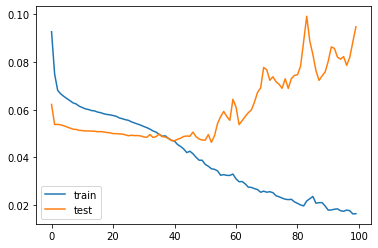

Test RMSE: %.3f Train RMSE: 70.790 28.224211620039327
(46, 1, 8) (46,) (12, 1, 8) (12,)
Train on 46 samples, validate on 12 samples
Epoch 1/100
46/46 [==============================] - 7s 150ms/step - loss: 0.0900 - val_loss: 0.0567
Epoch 2/100
46/46 [==============================] - 1s 13ms/step - loss: 0.0706 - val_loss: 0.0539
Epoch 3/100
46/46 [==============================] - 1s 14ms/step - loss: 0.0678 - val_loss: 0.0532
Epoch 4/100
46/46 [==============================] - 1s 13ms/step - loss: 0.0665 - val_loss: 0.0525
Epoch 5/100
46/46 [==============================] - 1s 13ms/step - loss: 0.0654 - val_loss: 0.0518
Epoch 6/100
46/46 [==============================] - 1s 13ms/step - loss: 0.0643 - val_loss: 0.0511
Epoch 7/100
46/46 [==============================] - 1s 14ms/step - loss: 0.0636 - val_loss: 0.0508
Epoch 8/100
46/46 [==============================] - 1s 13ms/step - loss: 0.0631 - val_loss: 0.0506
Epoch 9/100
46/46 [==============================] - 1s 14ms/step -

Epoch 81/100
46/46 [==============================] - 1s 12ms/step - loss: 0.0336 - val_loss: 0.0433
Epoch 82/100
46/46 [==============================] - 1s 13ms/step - loss: 0.0300 - val_loss: 0.0366
Epoch 83/100
46/46 [==============================] - 1s 12ms/step - loss: 0.0296 - val_loss: 0.0404
Epoch 84/100
46/46 [==============================] - 1s 12ms/step - loss: 0.0273 - val_loss: 0.0416
Epoch 85/100
46/46 [==============================] - 1s 12ms/step - loss: 0.0266 - val_loss: 0.0433
Epoch 86/100
46/46 [==============================] - 1s 13ms/step - loss: 0.0261 - val_loss: 0.0434
Epoch 87/100
46/46 [==============================] - 1s 12ms/step - loss: 0.0262 - val_loss: 0.0451
Epoch 88/100
46/46 [==============================] - 1s 12ms/step - loss: 0.0257 - val_loss: 0.0443
Epoch 89/100
46/46 [==============================] - 1s 13ms/step - loss: 0.0246 - val_loss: 0.0470
Epoch 90/100
46/46 [==============================] - 1s 13ms/step - loss: 0.0244 - val_los

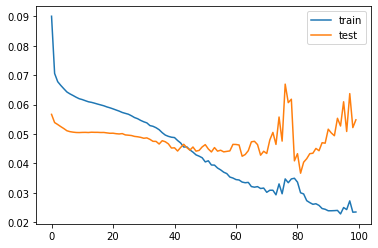

Test RMSE: %.3f Train RMSE: 53.847 32.66796228182092
(46, 1, 8) (46,) (12, 1, 8) (12,)
Train on 46 samples, validate on 12 samples
Epoch 1/100
46/46 [==============================] - 7s 147ms/step - loss: 0.0863 - val_loss: 0.0542
Epoch 2/100
46/46 [==============================] - 1s 14ms/step - loss: 0.0693 - val_loss: 0.0536
Epoch 3/100
46/46 [==============================] - 1s 14ms/step - loss: 0.0674 - val_loss: 0.0527
Epoch 4/100
46/46 [==============================] - 1s 14ms/step - loss: 0.0660 - val_loss: 0.0520
Epoch 5/100
46/46 [==============================] - 1s 14ms/step - loss: 0.0648 - val_loss: 0.0513
Epoch 6/100
46/46 [==============================] - 1s 14ms/step - loss: 0.0641 - val_loss: 0.0509
Epoch 7/100
46/46 [==============================] - 1s 14ms/step - loss: 0.0633 - val_loss: 0.0505
Epoch 8/100
46/46 [==============================] - 1s 14ms/step - loss: 0.0634 - val_loss: 0.0506
Epoch 9/100
46/46 [==============================] - 1s 13ms/step - 

Epoch 81/100
46/46 [==============================] - 1s 15ms/step - loss: 0.0229 - val_loss: 0.0477
Epoch 82/100
46/46 [==============================] - 1s 14ms/step - loss: 0.0238 - val_loss: 0.0446
Epoch 83/100
46/46 [==============================] - 1s 14ms/step - loss: 0.0215 - val_loss: 0.0474
Epoch 84/100
46/46 [==============================] - 1s 15ms/step - loss: 0.0197 - val_loss: 0.0610
Epoch 85/100
46/46 [==============================] - 1s 14ms/step - loss: 0.0204 - val_loss: 0.0711
Epoch 86/100
46/46 [==============================] - 1s 14ms/step - loss: 0.0252 - val_loss: 0.0760
Epoch 87/100
46/46 [==============================] - 1s 14ms/step - loss: 0.0296 - val_loss: 0.0717
Epoch 88/100
46/46 [==============================] - 1s 14ms/step - loss: 0.0322 - val_loss: 0.0457
Epoch 89/100
46/46 [==============================] - 1s 14ms/step - loss: 0.0221 - val_loss: 0.0414
Epoch 90/100
46/46 [==============================] - 1s 14ms/step - loss: 0.0213 - val_los

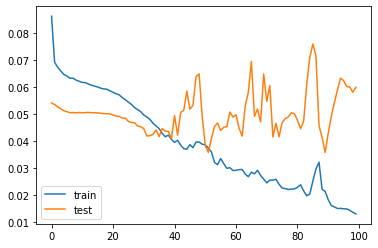

Test RMSE: %.3f Train RMSE: 56.328 23.342572702281576
(46, 1, 8) (46,) (12, 1, 8) (12,)
Train on 46 samples, validate on 12 samples
Epoch 1/100
46/46 [==============================] - 7s 156ms/step - loss: 0.0853 - val_loss: 0.0540
Epoch 2/100
46/46 [==============================] - 1s 18ms/step - loss: 0.0688 - val_loss: 0.0533
Epoch 3/100
46/46 [==============================] - 1s 18ms/step - loss: 0.0673 - val_loss: 0.0526
Epoch 4/100
46/46 [==============================] - 1s 17ms/step - loss: 0.0657 - val_loss: 0.0517
Epoch 5/100
46/46 [==============================] - 1s 17ms/step - loss: 0.0650 - val_loss: 0.0513
Epoch 6/100
46/46 [==============================] - 1s 17ms/step - loss: 0.0641 - val_loss: 0.0510
Epoch 7/100
46/46 [==============================] - 1s 17ms/step - loss: 0.0635 - val_loss: 0.0509
Epoch 8/100
46/46 [==============================] - 1s 17ms/step - loss: 0.0631 - val_loss: 0.0508
Epoch 9/100
46/46 [==============================] - 1s 17ms/step -

Epoch 81/100
46/46 [==============================] - 1s 18ms/step - loss: 0.0161 - val_loss: 0.1004
Epoch 82/100
46/46 [==============================] - 1s 18ms/step - loss: 0.0143 - val_loss: 0.1037
Epoch 83/100
46/46 [==============================] - 1s 18ms/step - loss: 0.0143 - val_loss: 0.1040
Epoch 84/100
46/46 [==============================] - 1s 18ms/step - loss: 0.0162 - val_loss: 0.0985
Epoch 85/100
46/46 [==============================] - 1s 18ms/step - loss: 0.0177 - val_loss: 0.1038
Epoch 86/100
46/46 [==============================] - 1s 18ms/step - loss: 0.0159 - val_loss: 0.1085
Epoch 87/100
46/46 [==============================] - 1s 18ms/step - loss: 0.0140 - val_loss: 0.1204
Epoch 88/100
46/46 [==============================] - 1s 18ms/step - loss: 0.0142 - val_loss: 0.1125
Epoch 89/100
46/46 [==============================] - 1s 17ms/step - loss: 0.0183 - val_loss: 0.1141
Epoch 90/100
46/46 [==============================] - 1s 17ms/step - loss: 0.0176 - val_los

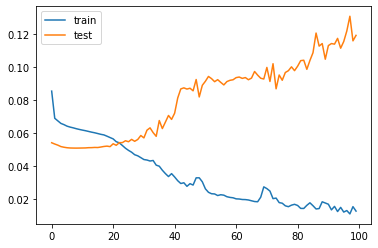

Test RMSE: %.3f Train RMSE: 79.345 24.447463430143042
(46, 1, 8) (46,) (12, 1, 8) (12,)
Train on 46 samples, validate on 12 samples
Epoch 1/100
46/46 [==============================] - 7s 158ms/step - loss: 0.0836 - val_loss: 0.0539
Epoch 2/100
46/46 [==============================] - 1s 16ms/step - loss: 0.0686 - val_loss: 0.0526
Epoch 3/100
46/46 [==============================] - 1s 17ms/step - loss: 0.0672 - val_loss: 0.0518
Epoch 4/100
46/46 [==============================] - 1s 17ms/step - loss: 0.0659 - val_loss: 0.0511
Epoch 5/100
46/46 [==============================] - 1s 17ms/step - loss: 0.0649 - val_loss: 0.0507
Epoch 6/100
46/46 [==============================] - 1s 16ms/step - loss: 0.0649 - val_loss: 0.0507
Epoch 7/100
46/46 [==============================] - 1s 16ms/step - loss: 0.0640 - val_loss: 0.0506
Epoch 8/100
46/46 [==============================] - 1s 16ms/step - loss: 0.0635 - val_loss: 0.0507
Epoch 9/100
46/46 [==============================] - 1s 17ms/step -

Epoch 81/100
46/46 [==============================] - 1s 17ms/step - loss: 0.0126 - val_loss: 0.1269
Epoch 82/100
46/46 [==============================] - 1s 16ms/step - loss: 0.0164 - val_loss: 0.1361
Epoch 83/100
46/46 [==============================] - 1s 16ms/step - loss: 0.0127 - val_loss: 0.1278
Epoch 84/100
46/46 [==============================] - 1s 16ms/step - loss: 0.0130 - val_loss: 0.1285
Epoch 85/100
46/46 [==============================] - 1s 16ms/step - loss: 0.0100 - val_loss: 0.1292
Epoch 86/100
46/46 [==============================] - 1s 16ms/step - loss: 0.0105 - val_loss: 0.1333
Epoch 87/100
46/46 [==============================] - 1s 16ms/step - loss: 0.0085 - val_loss: 0.1342
Epoch 88/100
46/46 [==============================] - 1s 16ms/step - loss: 0.0086 - val_loss: 0.1336
Epoch 89/100
46/46 [==============================] - 1s 16ms/step - loss: 0.0078 - val_loss: 0.1359
Epoch 90/100
46/46 [==============================] - 1s 16ms/step - loss: 0.0077 - val_los

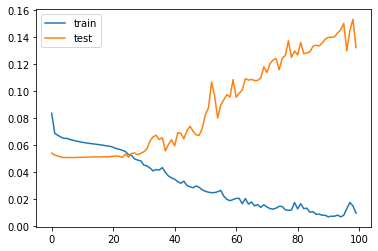

Test RMSE: %.3f Train RMSE: 83.671 17.987840992048923
(46, 1, 8) (46,) (12, 1, 8) (12,)
Train on 46 samples, validate on 12 samples
Epoch 1/100
46/46 [==============================] - 7s 155ms/step - loss: 0.0824 - val_loss: 0.0534
Epoch 2/100
46/46 [==============================] - 1s 14ms/step - loss: 0.0685 - val_loss: 0.0517
Epoch 3/100
46/46 [==============================] - 1s 14ms/step - loss: 0.0674 - val_loss: 0.0510
Epoch 4/100
46/46 [==============================] - 1s 15ms/step - loss: 0.0660 - val_loss: 0.0505
Epoch 5/100
46/46 [==============================] - 1s 15ms/step - loss: 0.0653 - val_loss: 0.0504
Epoch 6/100
46/46 [==============================] - 1s 14ms/step - loss: 0.0646 - val_loss: 0.0503
Epoch 7/100
46/46 [==============================] - 1s 15ms/step - loss: 0.0640 - val_loss: 0.0505
Epoch 8/100
46/46 [==============================] - 1s 15ms/step - loss: 0.0635 - val_loss: 0.0506
Epoch 9/100
46/46 [==============================] - 1s 15ms/step -

Epoch 81/100
46/46 [==============================] - 1s 15ms/step - loss: 0.0112 - val_loss: 0.1355
Epoch 82/100
46/46 [==============================] - 1s 15ms/step - loss: 0.0106 - val_loss: 0.1277
Epoch 83/100
46/46 [==============================] - 1s 16ms/step - loss: 0.0111 - val_loss: 0.1371
Epoch 84/100
46/46 [==============================] - 1s 15ms/step - loss: 0.0099 - val_loss: 0.1271
Epoch 85/100
46/46 [==============================] - 1s 17ms/step - loss: 0.0118 - val_loss: 0.1398
Epoch 86/100
46/46 [==============================] - 1s 15ms/step - loss: 0.0106 - val_loss: 0.1288
Epoch 87/100
46/46 [==============================] - 1s 15ms/step - loss: 0.0119 - val_loss: 0.1361
Epoch 88/100
46/46 [==============================] - 1s 15ms/step - loss: 0.0099 - val_loss: 0.1265
Epoch 89/100
46/46 [==============================] - 1s 15ms/step - loss: 0.0097 - val_loss: 0.1401
Epoch 90/100
46/46 [==============================] - 1s 15ms/step - loss: 0.0087 - val_los

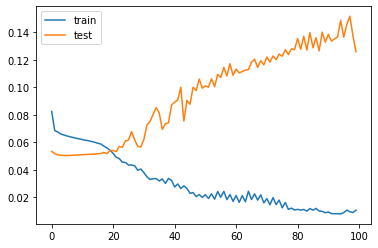

Test RMSE: %.3f Train RMSE: 81.607 22.823238926639846
(46, 1, 8) (46,) (12, 1, 8) (12,)
Train on 46 samples, validate on 12 samples
Epoch 1/100
46/46 [==============================] - 8s 164ms/step - loss: 0.0808 - val_loss: 0.0532
Epoch 2/100
46/46 [==============================] - 1s 20ms/step - loss: 0.0688 - val_loss: 0.0515
Epoch 3/100
46/46 [==============================] - 1s 20ms/step - loss: 0.0674 - val_loss: 0.0508
Epoch 4/100
46/46 [==============================] - 1s 20ms/step - loss: 0.0664 - val_loss: 0.0504
Epoch 5/100
46/46 [==============================] - 1s 20ms/step - loss: 0.0658 - val_loss: 0.0504
Epoch 6/100
46/46 [==============================] - 1s 20ms/step - loss: 0.0650 - val_loss: 0.0504
Epoch 7/100
46/46 [==============================] - 1s 20ms/step - loss: 0.0642 - val_loss: 0.0505
Epoch 8/100
46/46 [==============================] - 1s 20ms/step - loss: 0.0635 - val_loss: 0.0506
Epoch 9/100
46/46 [==============================] - 1s 20ms/step -

Epoch 81/100
46/46 [==============================] - 1s 20ms/step - loss: 0.0157 - val_loss: 0.1468
Epoch 82/100
46/46 [==============================] - 1s 20ms/step - loss: 0.0115 - val_loss: 0.1424
Epoch 83/100
46/46 [==============================] - 1s 21ms/step - loss: 0.0114 - val_loss: 0.1467
Epoch 84/100
46/46 [==============================] - 1s 22ms/step - loss: 0.0101 - val_loss: 0.1414
Epoch 85/100
46/46 [==============================] - 1s 21ms/step - loss: 0.0126 - val_loss: 0.1477
Epoch 86/100
46/46 [==============================] - 1s 22ms/step - loss: 0.0101 - val_loss: 0.1429
Epoch 87/100
46/46 [==============================] - 1s 22ms/step - loss: 0.0102 - val_loss: 0.1516
Epoch 88/100
46/46 [==============================] - 1s 21ms/step - loss: 0.0091 - val_loss: 0.1471
Epoch 89/100
46/46 [==============================] - 1s 20ms/step - loss: 0.0100 - val_loss: 0.1571
Epoch 90/100
46/46 [==============================] - 1s 20ms/step - loss: 0.0098 - val_los

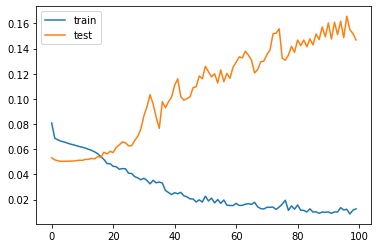

Test RMSE: %.3f Train RMSE: 88.138 25.289565210457507
(46, 1, 8) (46,) (12, 1, 8) (12,)
Train on 46 samples, validate on 12 samples
Epoch 1/100
46/46 [==============================] - 8s 173ms/step - loss: 0.0814 - val_loss: 0.0530
Epoch 2/100
46/46 [==============================] - 1s 25ms/step - loss: 0.0689 - val_loss: 0.0513
Epoch 3/100
46/46 [==============================] - 1s 26ms/step - loss: 0.0677 - val_loss: 0.0505
Epoch 4/100
46/46 [==============================] - 1s 25ms/step - loss: 0.0670 - val_loss: 0.0502
Epoch 5/100
46/46 [==============================] - 1s 25ms/step - loss: 0.0658 - val_loss: 0.0503
Epoch 6/100
46/46 [==============================] - 1s 25ms/step - loss: 0.0650 - val_loss: 0.0503
Epoch 7/100
46/46 [==============================] - 1s 26ms/step - loss: 0.0643 - val_loss: 0.0506
Epoch 8/100
46/46 [==============================] - 1s 25ms/step - loss: 0.0636 - val_loss: 0.0507
Epoch 9/100
46/46 [==============================] - 1s 26ms/step -

Epoch 81/100
46/46 [==============================] - 1s 25ms/step - loss: 0.0119 - val_loss: 0.1461
Epoch 82/100
46/46 [==============================] - 1s 25ms/step - loss: 0.0112 - val_loss: 0.1440
Epoch 83/100
46/46 [==============================] - 1s 25ms/step - loss: 0.0112 - val_loss: 0.1524
Epoch 84/100
46/46 [==============================] - 1s 27ms/step - loss: 0.0104 - val_loss: 0.1465
Epoch 85/100
46/46 [==============================] - 1s 25ms/step - loss: 0.0104 - val_loss: 0.1562
Epoch 86/100
46/46 [==============================] - 1s 25ms/step - loss: 0.0102 - val_loss: 0.1531
Epoch 87/100
46/46 [==============================] - 1s 25ms/step - loss: 0.0108 - val_loss: 0.1695
Epoch 88/100
46/46 [==============================] - 1s 26ms/step - loss: 0.0101 - val_loss: 0.1519
Epoch 89/100
46/46 [==============================] - 1s 25ms/step - loss: 0.0115 - val_loss: 0.1642
Epoch 90/100
46/46 [==============================] - 1s 27ms/step - loss: 0.0113 - val_los

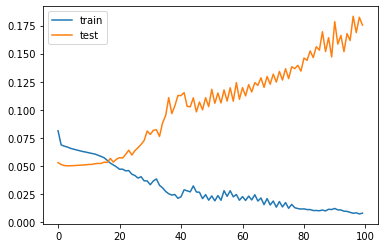

Test RMSE: %.3f Train RMSE: 96.326 17.226074761644806
(46, 1, 8) (46,) (12, 1, 8) (12,)
Train on 46 samples, validate on 12 samples
Epoch 1/100
46/46 [==============================] - 9s 190ms/step - loss: 0.0803 - val_loss: 0.0522
Epoch 2/100
46/46 [==============================] - 2s 33ms/step - loss: 0.0688 - val_loss: 0.0510
Epoch 3/100
46/46 [==============================] - 2s 33ms/step - loss: 0.0680 - val_loss: 0.0503
Epoch 4/100
46/46 [==============================] - 2s 33ms/step - loss: 0.0670 - val_loss: 0.0502
Epoch 5/100
46/46 [==============================] - 2s 33ms/step - loss: 0.0661 - val_loss: 0.0502
Epoch 6/100
46/46 [==============================] - 2s 33ms/step - loss: 0.0650 - val_loss: 0.0504
Epoch 7/100
46/46 [==============================] - 1s 32ms/step - loss: 0.0643 - val_loss: 0.0505
Epoch 8/100
46/46 [==============================] - 2s 33ms/step - loss: 0.0636 - val_loss: 0.0509
Epoch 9/100
46/46 [==============================] - 2s 34ms/step -

Epoch 81/100
46/46 [==============================] - 1s 32ms/step - loss: 0.0103 - val_loss: 0.1537
Epoch 82/100
46/46 [==============================] - 1s 32ms/step - loss: 0.0096 - val_loss: 0.1618
Epoch 83/100
46/46 [==============================] - 2s 34ms/step - loss: 0.0099 - val_loss: 0.1601
Epoch 84/100
46/46 [==============================] - 2s 33ms/step - loss: 0.0114 - val_loss: 0.1673
Epoch 85/100
46/46 [==============================] - 2s 33ms/step - loss: 0.0112 - val_loss: 0.1557
Epoch 86/100
46/46 [==============================] - 2s 34ms/step - loss: 0.0098 - val_loss: 0.1713
Epoch 87/100
46/46 [==============================] - 2s 33ms/step - loss: 0.0095 - val_loss: 0.1519
Epoch 88/100
46/46 [==============================] - 1s 32ms/step - loss: 0.0165 - val_loss: 0.1608
Epoch 89/100
46/46 [==============================] - 1s 32ms/step - loss: 0.0148 - val_loss: 0.1477
Epoch 90/100
46/46 [==============================] - 1s 32ms/step - loss: 0.0149 - val_los

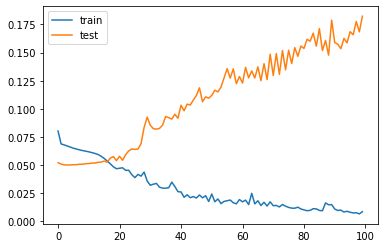

Test RMSE: %.3f Train RMSE: 98.189 19.23059531938581
(46, 1, 8) (46,) (12, 1, 8) (12,)
Train on 46 samples, validate on 12 samples
Epoch 1/100
46/46 [==============================] - 9s 199ms/step - loss: 0.0805 - val_loss: 0.0523
Epoch 2/100
46/46 [==============================] - 2s 38ms/step - loss: 0.0693 - val_loss: 0.0510
Epoch 3/100
46/46 [==============================] - 2s 38ms/step - loss: 0.0678 - val_loss: 0.0504
Epoch 4/100
46/46 [==============================] - 2s 38ms/step - loss: 0.0669 - val_loss: 0.0502
Epoch 5/100
46/46 [==============================] - 2s 39ms/step - loss: 0.0659 - val_loss: 0.0504
Epoch 6/100
46/46 [==============================] - 2s 38ms/step - loss: 0.0653 - val_loss: 0.0506
Epoch 7/100
46/46 [==============================] - 2s 38ms/step - loss: 0.0644 - val_loss: 0.0508
Epoch 8/100
46/46 [==============================] - 2s 38ms/step - loss: 0.0638 - val_loss: 0.0511
Epoch 9/100
46/46 [==============================] - 2s 40ms/step - 

Epoch 81/100
46/46 [==============================] - 2s 39ms/step - loss: 0.0155 - val_loss: 0.1330
Epoch 82/100
46/46 [==============================] - 2s 40ms/step - loss: 0.0197 - val_loss: 0.1427
Epoch 83/100
46/46 [==============================] - 2s 39ms/step - loss: 0.0157 - val_loss: 0.1354
Epoch 84/100
46/46 [==============================] - 2s 37ms/step - loss: 0.0187 - val_loss: 0.1445
Epoch 85/100
46/46 [==============================] - 2s 38ms/step - loss: 0.0135 - val_loss: 0.1419
Epoch 86/100
46/46 [==============================] - 2s 39ms/step - loss: 0.0174 - val_loss: 0.1491
Epoch 87/100
46/46 [==============================] - 2s 38ms/step - loss: 0.0129 - val_loss: 0.1379
Epoch 88/100
46/46 [==============================] - 2s 38ms/step - loss: 0.0170 - val_loss: 0.1488
Epoch 89/100
46/46 [==============================] - 2s 39ms/step - loss: 0.0124 - val_loss: 0.1423
Epoch 90/100
46/46 [==============================] - 2s 39ms/step - loss: 0.0159 - val_los

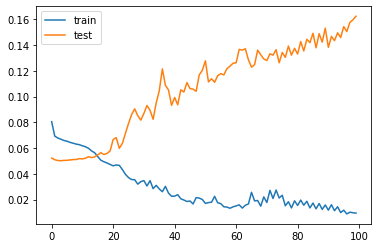

Test RMSE: %.3f Train RMSE: 92.676 18.490242938092795


1127.8707278000002

In [184]:
tic = time.clock()
data=list(dftScaled[0])
n_vars = 1 if type(data) is list else data.shape[1]
df = pd.DataFrame(data)
counter = 0
myDict = {}
for k in (50,100,150,200,250,300,350,400,450,500):
    counter += 1
    n_in=7
    n_out=1
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    agg['number of fractures(t)']=list(welltScaled[0])
    agg.dropna(inplace=True)
    cols = agg.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    agg = agg[cols]

    #Split into train and test
    values = agg.values
    train_size = int(values.shape[0] * 0.8)
    train=values[:train_size,:]
    test=values[train_size:,:]
    test.shape
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]

    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

    #design the model
    model = Sequential()
    model.add(LSTM(k,return_sequences=True,input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(LSTM(k,activation='relu'))
    #model.add(Dense(1))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # fit network
    history = model.fit(train_X, train_y, epochs=100, batch_size=1, validation_data=(test_X, test_y), shuffle=False)

    # plot history
    import matplotlib.pyplot as plt
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()

    #Prediction
    test_pr = model.predict(test_X)
    train_pr=model.predict(train_X)
    train_pr_inv=scaler.inverse_transform(train_pr)
    test_pr_inv=scaler.inverse_transform(test_pr)
    prediction=np.vstack((train_pr_inv, test_pr_inv))
    dftb=dft[-(65-n_in):]
    dftb['pred']=prediction
    train_inv=dftb['w'][:train_size]
    test_inv=dftb['w'][train_size:]
    
    ## calculate RMSE
    rmse_test = sqrt(mean_squared_error(test_inv, test_pr_inv))
    rmse_train=sqrt(mean_squared_error(train_inv, train_pr_inv))
    print('Test RMSE: %.3f','Train RMSE: %.3f' % rmse_test,rmse_train)
    myDict[counter] = [k, rmse_train,rmse_test]
dict_to_df = pd.DataFrame.from_dict(myDict,orient='index')
toc = time.clock()
toc - tic


In [185]:
dict_to_df.to_csv('StackLSTM_input7_epo100.csv')

In [186]:
dict_to_df.set_index(0,drop=True,inplace=True)
dict_to_df.columns=['train error','test error']

Text(0.5, 1.0, 'StackedLSTM Nodes (no. of input=7, epoch=100)')

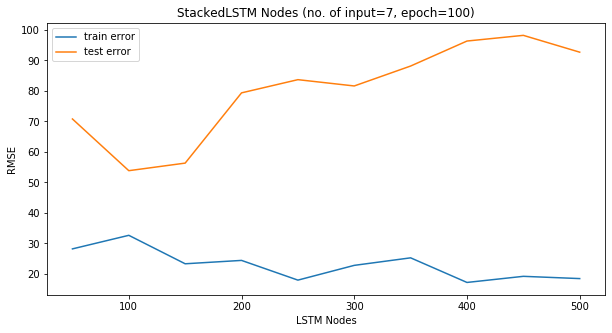

In [187]:
dict_to_df.columns=['train error','test error']
dict_to_df.plot(figsize=(10,5))
plt.xlabel('LSTM Nodes')
plt.ylabel('RMSE')
plt.title('StackedLSTM Nodes (no. of input=7, epoch=100)')